In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(1)

In [2]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [97]:
#random_state in the train test split has been set to 1 to recreate results, remove it to review model
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)
#new feature "new" has been engineered to be able to use the votes provided by viewers while trying to 
#give importance to number of voters
df_numeric['new'] = df_numeric['vote_average']*np.power(df_numeric['vote_count'],0.9)
train,test = train_test_split(df_numeric,test_size=0.25,random_state = 1)

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [98]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

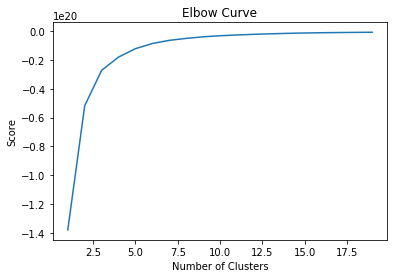

In [99]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [100]:
#we look at the graph and not that elbow is at 4 and hence we choose 4 as cluster number
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [101]:
print('Size of clusters : ',[len(train[train.cluster==i]) for i in range(4)])

Size of clusters :  [25489, 285, 1069, 68]


In [102]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count,new
cluster,,,,,,,
0,6.350458e+06,2.709110,9.345350e+06,95.762525,5.612786,54.779944,204.677415
1,9.832656e+07,18.084069,4.020556e+08,119.133333,6.622105,2768.150877,8450.181201
2,4.654469e+07,11.514855,1.344585e+08,111.823199,6.322544,989.276894,3153.122873
3,1.611176e+08,43.413802,9.701065e+08,130.544118,6.980882,5767.132353,17158.682941


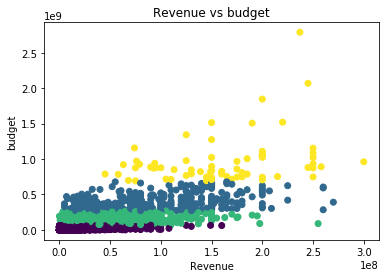

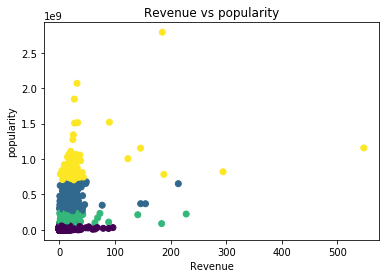

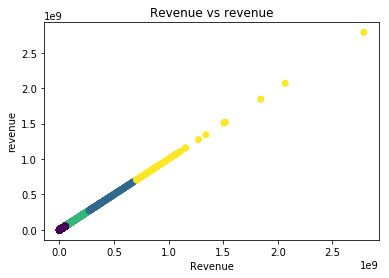

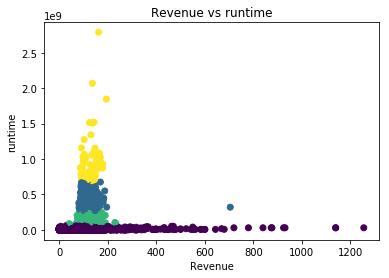

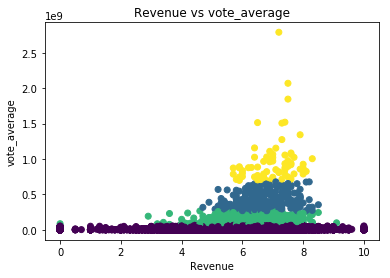

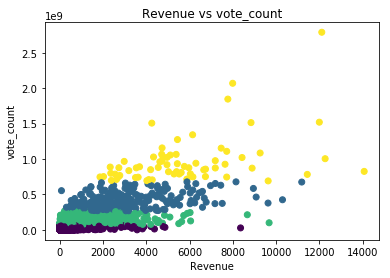

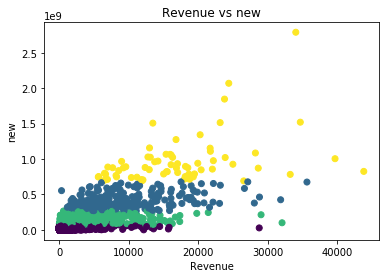

In [103]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
for i in train.iloc[:,:-1]:
    plt.scatter(train[i],train['revenue'],c=kmeans.labels_)
    plt.xlabel("Revenue")
    plt.ylabel(i)
    plt.title('Revenue vs '+i)
    plt.show()

In [104]:
cluster1 = train[train.cluster==0]
cluster1 = cluster1[cluster1.revenue!=0]
print('Size of cluster 1: ',len(cluster1))

Size of cluster 1:  25489


In [105]:
#we can observe clusters in the train and test dataset
test_clusters = kmeans.predict(test.revenue.values.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        6.350458e+06    2.709110  9.345350e+06   95.762525      5.612786   
1        9.832656e+07   18.084069  4.020556e+08  119.133333      6.622105   
2        4.654469e+07   11.514855  1.344585e+08  111.823199      6.322544   
3        1.611176e+08   43.413802  9.701065e+08  130.544118      6.980882   

          vote_count           new  
cluster                             
0          54.779944    204.677415  
1        2768.150877   8450.181201  
2         989.276894   3153.122873  
3        5767.132353  17158.682941  
               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        6.194765e+06    2.654288  9.180692e+06   95.464025      5.626858   
1        9.367163e+07   15.386084  4.027717e+08  114.481481      6.604938   
2      

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
from datetime import datetime
meaan = []
meta.loc[:,'release_date']=pd.to_datetime(meta.release_date, format = '%Y-%m-%d', errors="coerce")
for i in range(1970,2018,5):
    mask = (meta['release_date'] >= str(i)+'-1-1') & (meta['release_date'] < str(i+5)+'-1-1')
    tdf = meta[mask]
    tdf = tdf.sort_values(['release_date'])
    dates = np.array([j for j in tdf.release_date])
    print(str(i)+" To "+str(i+5))
    print("Mean budget "+str(tdf.budget.mean()))
    meaan.append(tdf.budget.mean())
#Indicates an increase in budget over the years. Here every 5 years from 1970 onwards is taken. This is to show that the 
#inflation of the prices over the years need not be separately accounted using any factor as the budget itself is increasing
#across the years
rates = [meaan[i+1]/meaan[i] for i in range(len(meaan)-1)]
rates.insert(0,1)
rates = [i**-1 for i in rates]
print(rates)

1970 To 1975
Mean budget 3974821.8489795895
1975 To 1980
Mean budget 5058210.009956439
1980 To 1985
Mean budget 6237558.713207546
1985 To 1990
Mean budget 7154245.465861904
1990 To 1995
Mean budget 8928339.321781304
1995 To 2000
Mean budget 10978235.28391089
2000 To 2005
Mean budget 11442742.047681492
2005 To 2010
Mean budget 10199704.366859054
2010 To 2015
Mean budget 9514546.082900317
2015 To 2020
Mean budget 10238400.227655722
[1.0, 0.7858158995288178, 0.8109278393237522, 0.8718681436038872, 0.8012963226440807, 0.8132763682762563, 0.9594059918649727, 1.1218699715318536, 1.0720116627728686, 0.9293000733844975]


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

RMSE = 37989573.06898047
LOG RMSE = 0.7242219822991659
R Sqaured = 0.7262588435662504


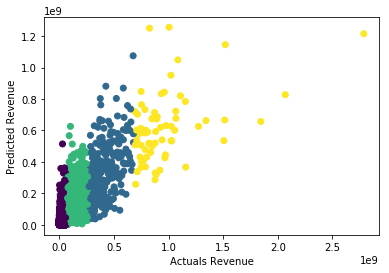

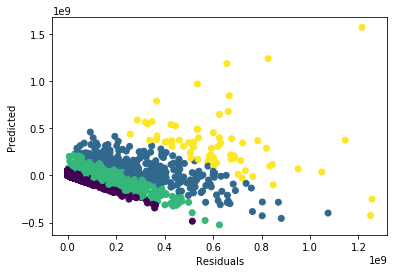

          revenue  revenue_pred  log_actuals  log_pred
6927   13030214.0  2.413570e+07     7.114952  7.382660
17774   1138739.4  1.705921e+06     6.056424  6.231959
3505    1703282.0  1.620271e+07     6.231287  7.209588
30506   5590706.0  1.108924e+06     6.747467  6.044902
24093   1836570.8  3.235021e+06     6.264008  6.509877


In [149]:
#Linear regression done on selected attributes
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


X = train[['budget','popularity','new']]
release = meta[['release_date']]
y = train[['revenue']]

lm = linear_model.LinearRegression(fit_intercept=False)
model = lm.fit(X,y)
predictions = lm.predict(X)
pred = pd.DataFrame(predictions,columns=["revenue"])
y['revenue_pred'] = predictions

for i in X.index:
    ind = (meta.iloc[i].release_date.year - 1970)//5
    y.loc[i].revenue_pred = y.loc[i].revenue_pred*rates[ind]

y['log_actuals'] = np.log10(y.revenue)
y['log_pred'] = np.log10(y.revenue_pred)

#RMSE is as follows
print("RMSE = "+str((mean_squared_error(y.revenue,y.revenue_pred))**0.5))
print("LOG RMSE = "+str((mean_squared_error(y.log_actuals,y.log_pred))**0.5))
#R Sqaured is as follows
print("R Sqaured = "+str(model.score(X,y.revenue)))
residuals = y.revenue - y.revenue_pred
plt.scatter(y.revenue,y.revenue_pred,c=kmeans.labels_)
plt.xlabel("Actuals Revenue")
plt.ylabel("Predicted Revenue")
plt.show()
plt.scatter(y.revenue_pred,residuals,c=kmeans.labels_)
plt.xlabel("Residuals")
plt.ylabel("Predicted")
plt.show()

print(y[6927].revenue_pred)